#### Name: Zhornichenko Ilya Alekseevich
#### Group: TMSS
#### Higher school of economics
#### Implementation for ARIMA model prediction algorithm

In [2]:
"""importing libraries"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sys
import warnings
import random

In [3]:
##Reading data

df = pd.read_fwf('lorenz.txt')
df.columns = ['Nums']
df.dropna()
print('Data shape', df.shape)

df_new = df.iloc[:1000]
df.head()
df_new.columns=['Value']
df.columns = ['Value']
df_new.head()

Data shape (100000, 1)


,Value
0,0.570390
1,0.686728
2,0.960674
3,0.853759
4,0.535661


In [4]:
def graph_builder(df_new): 
    plt.plot(df_new)
    plt.grid()
    plt.ylabel('target function')
    plt.xlabel('number of samples')
    plt.title('Random chaos generator')
    plt.show()
    


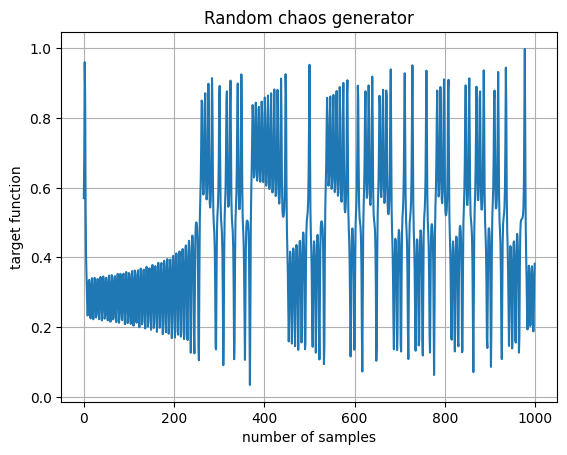

In [5]:
graph_builder(df_new)

In [6]:
#Checking out the consistency of genearated chaos(ARIMA model couldn't be implemented to statyionary TS)

parts  = int(len(df_new.values)/3)

part_1, part_2, part_3 = df_new.values[0:parts], df_new.values[parts:(
    parts*2)], df_new.values[(parts*2):(parts*3)]

mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()

var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()

print('mean1=%f, mean2=%f, mean2=%f' % (mean_1, mean_2, mean_3))

print('variance1=%f, variance2=%f, variance2=%f' % (var_1, var_2, var_3))

# So the data is considerably the same. (So the current TS is stationary)
# We can't use ARIMA model to Lorentz 

mean1=0.373113, mean2=0.553113, mean2=0.484501
variance1=0.029663, variance2=0.043306, variance2=0.043037


In [7]:
def chaos_generator(time, setup_iter):
    time_init      = 0
    time_terminate = time
    number_of_iters = setup_iter
    """measuring delta t"""
    dt =  (time_terminate - time_init)/ number_of_iters
    """for-loop for time series"""
    time = []
    set_random_points = []
    for i in np.arange(time_init , time_terminate - dt, dt): 
        time.append(i)
        set_random_points.append(random.random()) 


    return time, set_random_points

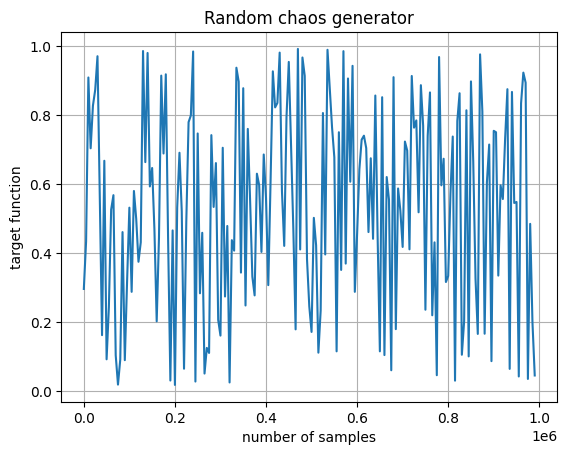

In [8]:
def display_graph(time_x , points_y): 
    plt.plot(time_x , points_y)
    plt.grid()
    plt.ylabel('target function')
    plt.xlabel('number of samples')
    plt.title('Random chaos generator')
    plt.show()
time_x , points_y = chaos_generator(1000000,200)
display_graph(time_x , points_y)

In [100]:
# MSE metrics evaluation
def MSE_metrics(actual, pred):
    actual, pred = np.array(actual), np.array(pred)

    return np.square(np.subtract(actual, pred).mean())

#### ARIMA model implementation

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


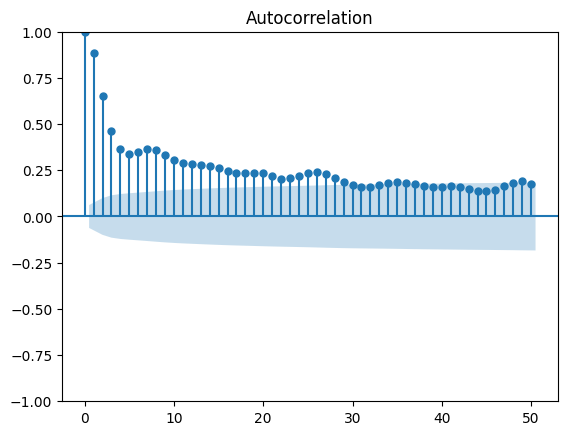

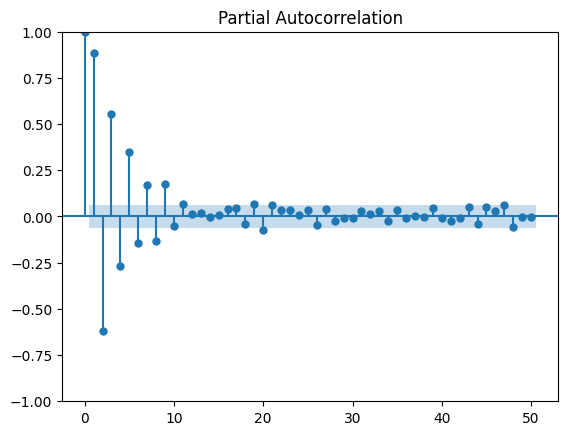

In [101]:
# Making data stationary and choosing p,q,d coefficients

ACF  = plot_acf(df_new.dropna(),lags=50)
PACF = plot_pacf(df_new.dropna(),lags=50)

In [102]:
### AutoRegression model 
def AR(p,df_new):
  df_temp = df_new 
  MSE = 0

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()
  

  #MSE evaluation 
  #for i in range(df_test['Value'].size): 
   # MSE = MSE + pow((df_test['Value'][i] - df_test['Predicted_Values'][i]),2)
  MSE = MSE_metrics(df_test['Value'], df_test['Predicted_Values'])

  #RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values'])) #RMSE = np.sqrt(MSE)
  RMSE = np.sqrt(25)

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,df_train,theta,intercept,RMSE]


In [103]:
AR(2, df)

The RMSE is : 5.0 , Value of p :  2


/var/folders/10/hpyry21n0y314q2c0pcgn9cr0000gn/T/ipykernel_72048/2908159698.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


[          Value  Shifted_values_1  Shifted_values_2  Predicted_Values
 2      0.960674          0.686728          0.570390          0.723387
 3      0.853759          0.960674          0.686728          1.038168
 4      0.535661          0.853759          0.960674          0.715400
 5      0.401061          0.535661          0.853759          0.332250
 6      0.343684          0.401061          0.535661          0.340935
 ...         ...               ...               ...               ...
 79995  0.525916          0.457102          0.259765          0.592941
 79996  0.560181          0.525916          0.457102          0.566772
 79997  0.612469          0.560181          0.525916          0.572175
 79998  0.723185          0.612469          0.560181          0.624709
 79999  0.885201          0.723185          0.612469          0.748629
 
 [79998 rows x 4 columns],
           Value  Shifted_values_1  Shifted_values_2  Predicted_Values
 80000  0.847030          0.885201          0.72

In [104]:
df_train_2, df_test, df_train, theta,intercept, RMSE = AR(2,df_new)

The RMSE is : 5.0 , Value of p :  2


/var/folders/10/hpyry21n0y314q2c0pcgn9cr0000gn/T/ipykernel_72048/2908159698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)
/var/folders/10/hpyry21n0y314q2c0pcgn9cr0000gn/T/ipykernel_72048/2908159698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)
/var/folders/10/hpyry21n0y314q2c0pcgn9cr0000gn/T/ipykernel_72048/2908159698.py:29: SettingWithCopyWarning: 
A value is trying to be 

In [115]:
### Measuroing moving average (MA)
df_c = pd.concat([df_train,df_test])
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values
res['Residuals'] = res['Residuals'].fillna(0)


In [116]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]


The RMSE is : 0.08232936473846104 , Value of q :  5


/var/folders/10/hpyry21n0y314q2c0pcgn9cr0000gn/T/ipykernel_72048/3062001387.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


[     Residuals  Shifted_values_1  Shifted_values_2  Shifted_values_3  \
 5          0.0               0.0               0.0               0.0   
 6          0.0               0.0               0.0               0.0   
 7          0.0               0.0               0.0               0.0   
 8          0.0               0.0               0.0               0.0   
 9          0.0               0.0               0.0               0.0   
 ..         ...               ...               ...               ...   
 795        0.0               0.0               0.0               0.0   
 796        0.0               0.0               0.0               0.0   
 797        0.0               0.0               0.0               0.0   
 798        0.0               0.0               0.0               0.0   
 799        0.0               0.0               0.0               0.0   
 
      Shifted_values_4  Shifted_values_5  Predicted_Values  
 5                 0.0               0.0               0.0  


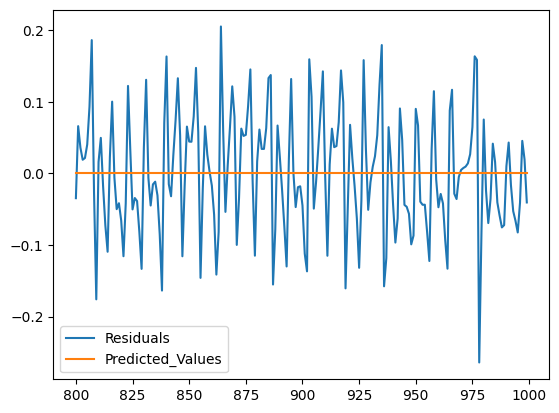

In [117]:
MA(5,res)